<a href="https://colab.research.google.com/github/is2295/Final-Project-Report-/blob/main/Second_and_third_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
# importing a packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense
from tensorflow.keras import layers, models, optimizers, losses, callbacks,\
                             regularizers
warnings.filterwarnings('ignore')

In [45]:
netflixStockDF = pd.read_csv('/content/drive/MyDrive/Project Work/NFLX_Dataset/NFLX.csv')
netflixStockDF.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
def preProcessing(Dataframe):
    '''
        Excluding divident and stock splits because it always zero
    '''
    Dataframe = Dataframe.drop(columns=['Dividends', 'Stock Splits'], errors='ignore')

    Dataframe['Date'] = pd.to_datetime(Dataframe['Date'])
    # Extrating a Number of year, month, week and day
    Dataframe['Year']  = Dataframe['Date'].dt.year
    Dataframe['Month'] = Dataframe['Date'].dt.month
    Dataframe['Week']  = Dataframe['Date'].dt.day_of_week
    Dataframe['Day']  = Dataframe['Date'].dt.day

    # Reordering a columns values
    Dataframe = Dataframe[['Year', 'Month', 'Week','Day','Open','High','Low', 'Close','Volume']]

    return Dataframe

In [48]:
netflixStockDF = preProcessing(netflixStockDF)
netflixStockDF

,Year,Month,Week,Day,Open,High,Low,Close,Volume
0,2018,2,0,5,262.000000,267.899994,250.029999,254.259995,11896100
1,2018,2,1,6,247.699997,266.700012,245.000000,265.720001,12595800
2,2018,2,2,7,266.579987,272.450012,264.329987,264.559998,8981500
3,2018,2,3,8,267.079987,267.619995,250.000000,250.100006,9306700
4,2018,2,4,9,253.850006,255.800003,236.110001,249.470001,16906900
...,...,...,...,...,...,...,...,...,...
1004,2022,1,0,31,401.970001,427.700012,398.200012,427.140015,20047500
1005,2022,2,1,1,432.959991,458.480011,425.540009,457.130005,22542300
1006,2022,2,2,2,448.250000,451.980011,426.480011,429.480011,14346000
1007,2022,2,3,3,421.440002,429.260010,404.279999,405.600006,9905200


In [49]:
# Summary of numerical Columns
netflixStockDF[['Open','High','Low', 'Close','Volume']].describe()

,Open,High,Low,Close,Volume
count,1009.000000,1009.000000,1009.000000,1009.000000,1.009000e+03
mean,419.059673,425.320703,412.374044,419.000733,7.570685e+06
std,108.537532,109.262960,107.555867,108.289999,5.465535e+06
min,233.919998,250.649994,231.229996,233.880005,1.144000e+06
25%,331.489990,336.299988,326.000000,331.619995,4.091900e+06
50%,377.769989,383.010010,370.880005,378.670013,5.934500e+06
75%,509.130005,515.630005,502.529999,509.079987,9.322400e+06
max,692.349976,700.989990,686.090027,691.690002,5.890430e+07


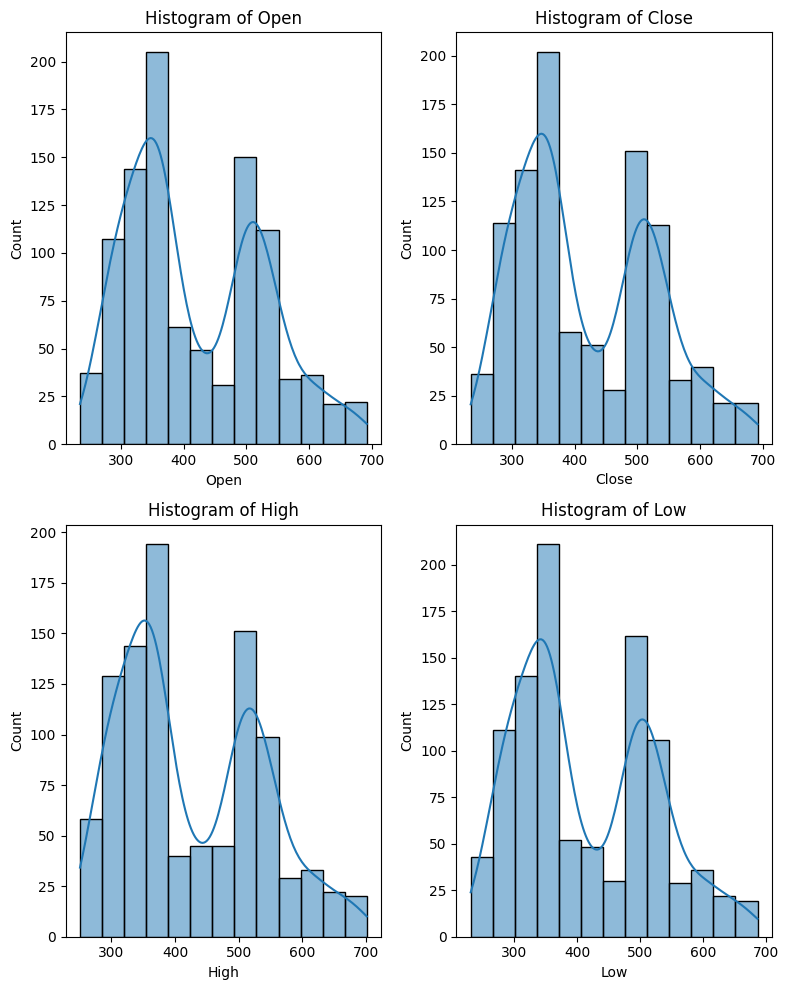

In [50]:
# Histogram plotting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,10))

netflixStockDF_col = ['Open','Close','High','Low']
for i, (colm, axes) in enumerate(zip(netflixStockDF_col, axes.flatten())):
  sns.histplot(data=netflixStockDF, x=colm, ax=axes, kde=True)
  axes.set_title(f'Histogram of {colm}')
plt.tight_layout()

            Open      High       Low     Close    Volume
Open    1.000000  0.998605  0.998508  0.996812 -0.415838
High    0.998605  1.000000  0.998203  0.998551 -0.400699
Low     0.998508  0.998203  1.000000  0.998544 -0.432116
Close   0.996812  0.998551  0.998544  1.000000 -0.413362
Volume -0.415838 -0.400699 -0.432116 -0.413362  1.000000


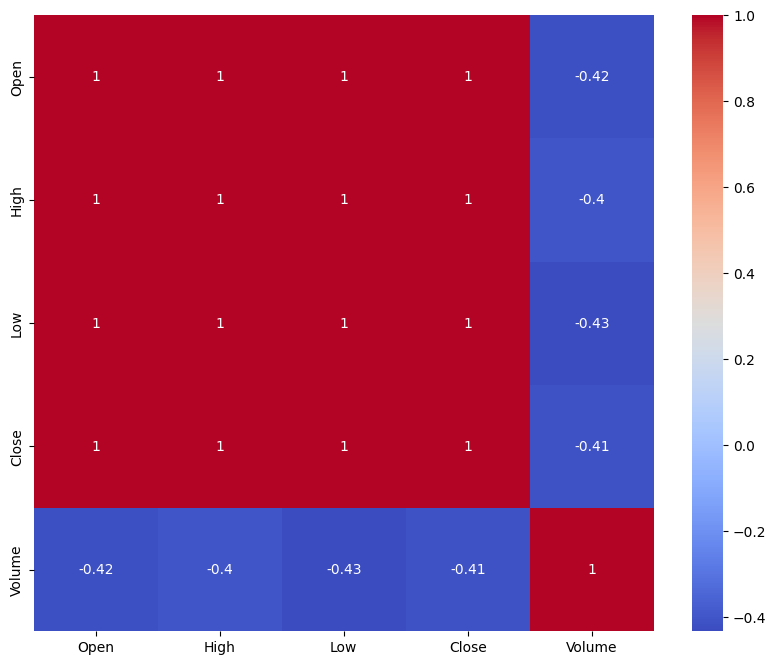

In [51]:
# Correlation matrix
corrmatrix_Netflix = netflixStockDF[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
print(corrmatrix_Netflix)

# Heatmap of the correlation
plt.figure(figsize=(10, 8))
sns.heatmap(corrmatrix_Netflix, annot=True, cmap='coolwarm')
plt.show()

In [52]:
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

# Set the number of timesteps
timesteps = 7

# Reshape your data
x = netflixStockDF[['Year','Month', 'Week', 'Day', 'Close']].values
y = netflixStockDF['Close'].values

# Create sequences
x, y = create_sequences(x, timesteps)

# Split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print('X_train shape :' ,x_train.shape)
print('X_test  shape :' ,x_test.shape)
print('Y_train shape :' ,y_train.shape)
print('Y_test  shape :' ,y_test.shape)

X_train shape : (801, 7, 5)
X_test  shape : (201, 7, 5)
Y_train shape : (801, 5)
Y_test  shape : (201, 5)


In [53]:
# Define the number of timesteps and features
timesteps = 7 # Number of previous days you consider to predict next day stock price
features = 5 # Number of features(Open, High, Low, Close, Volume)

# CNN Input Layer
input_Layer = layers.Input(shape = (timesteps, x_train.shape[2]), name='Input Shape')

# CNN Layer 1
conv_1        = Conv1D(filters=128, kernel_size=2, activation='relu', name = 'Conv_1')(input_Layer)
max_pooling_1 = MaxPool1D(pool_size=2, name = 'Maxpooling_1')(conv_1)
drop_1        = Dropout(0.1)(max_pooling_1)

# CNN Layer 2
conv_2        = Conv1D(filters=64, kernel_size=2, activation='relu', name = 'Conv_2')(drop_1)
max_pooling_2 = MaxPool1D(pool_size=2, name = 'Maxpooling_2')(conv_2)
drop_2        = Dropout(0.1)(max_pooling_2)



flatten = Flatten(name='flatten')(drop_2)
den_1 = Dense(1, activation='relu', name='fc_1')(flatten)

# Defining Models
cnn_model = models.Model(inputs = input_Layer, outputs=den_1, name = 'CNN_model')

# Summary of CNN Model
cnn_model.summary()


Model: "CNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input Shape (InputLayer)             │ (None, 7, 5)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv_1 (Conv1D)                      │ (None, 6, 128)              │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Maxpooling_1 (MaxPooling1D)          │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv_2 (Conv1D)                      │ (None, 2, 64)               │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Maxpooling_2 (MaxPooling1D)          │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,921 (70.00 KB)

 Trainable params: 17,921 (70.00 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
cnn_model.compile(optimizer='adam', loss=['mse'])
history = cnn_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 666381.3750 - val_loss: 610083.4375
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 617662.8750 - val_loss: 613285.1875
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 614637.4375 - val_loss: 611776.1875
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 613953.5000 - val_loss: 614859.0625
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 613021.6250 - val_loss: 616772.9375
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 612611.7500 - val_loss: 615733.3750
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 612798.3125 - val_loss: 615880.1875
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 612943.0000 - val_loss: 616217.6250
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 612778.0000 - val_loss: 618836.4375
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 612594.1250 - val_loss: 616660.4375


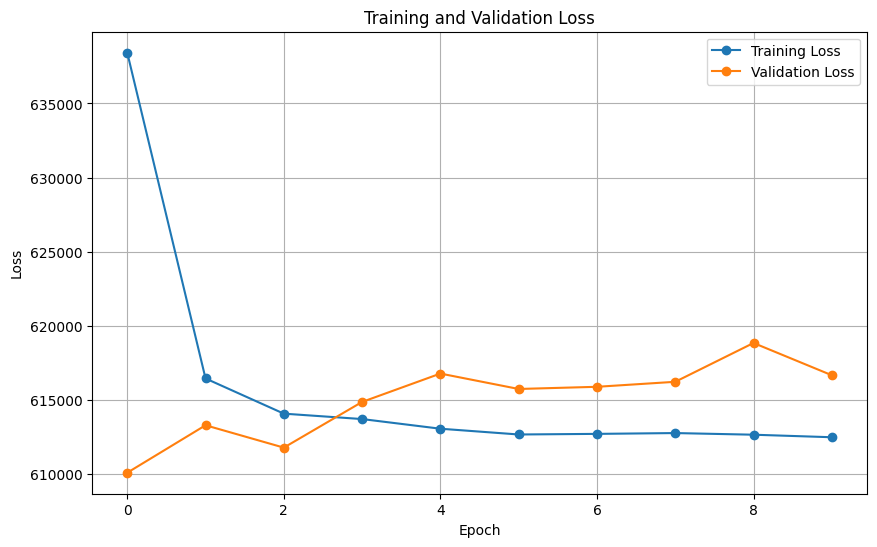

In [55]:
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting for the modle graph
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


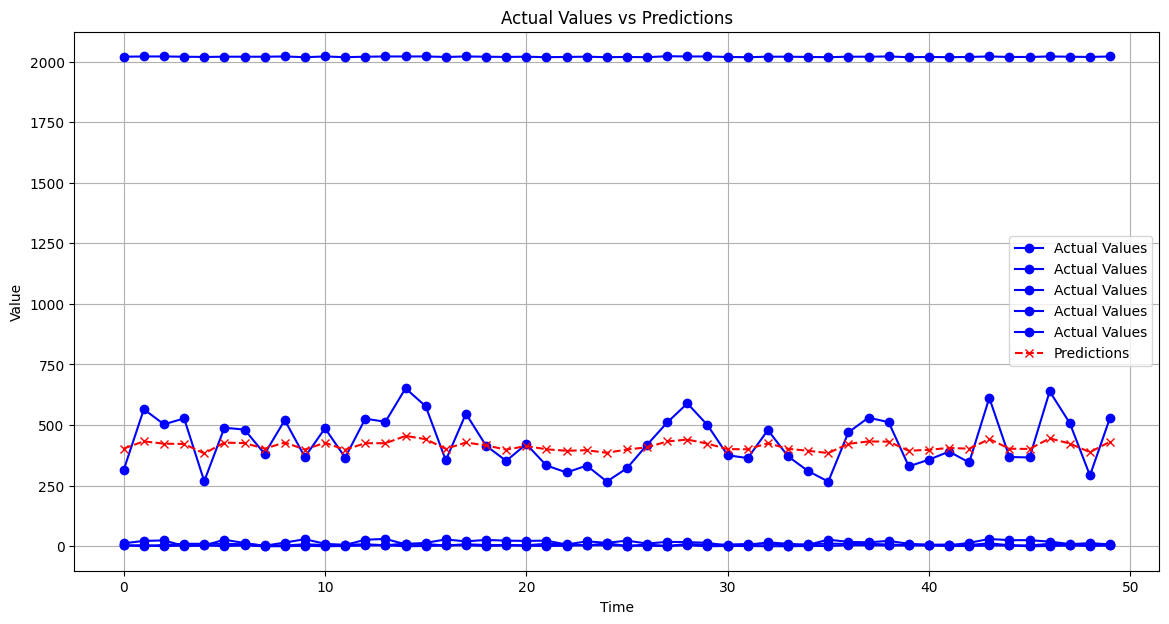

In [56]:
# prediction
pred_x_test = cnn_model.predict(x_test)

plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(y_test[:50], label='Actual Values', color='blue', linestyle='-', marker='o')

# Plot predictions
plt.plot(pred_x_test[:50], label='Predictions', color='red', linestyle='--', marker='x')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual Values vs Predictions')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
from statsmodels.tsa.arima.model import ARIMA
series = netflixStockDF['Close']

train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# Define the ARIMA model (replace p, d, q with actual values)
model = ARIMA(series, order=(10, 1, 0))
model_fit = model.fit()

# Print summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1009
Model:                ARIMA(10, 1, 0)   Log Likelihood               -3843.787
Date:                Thu, 29 Aug 2024   AIC                           7709.573
Time:                        13:31:18   BIC                           7763.646
Sample:                             0   HQIC                          7730.117
                               - 1009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0541      0.029     -1.867      0.062      -0.111       0.003
ar.L2          0.0152      0.027      0.571      0.568      -0.037       0.067
ar.L3          0.0123      0.031      0.391      0.6

In [58]:
# Predict on test data
predictions = model_fit.forecast(steps=len(test))
mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 28403.564005070883


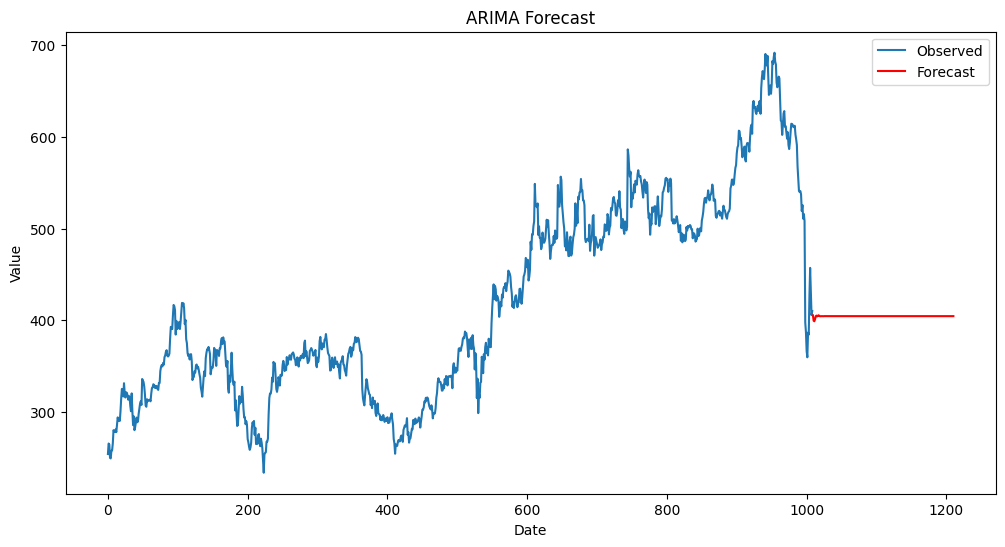

In [60]:
forecast = model_fit.forecast(steps=5)
forecast_index = pd.date_range(start=series.index[-1], periods=11 )
forecast_series = pd.Series(forecast, index=forecast_index)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(series, label='Observed')
plt.plot(predictions, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()